<a href="https://colab.research.google.com/github/SakibulIslamSazzad/IBMQuantumChallenge2020/blob/main/3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset
import itertools
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, IBMQ, execute
from qiskit.tools.visualization import plot_histogram
from qc_grader import grade_ex3, prepare_ex3, submit_ex3
provider = IBMQ.load_account()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-11-28 22:51:59,399: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
problem_set =    [[['0', '2'], ['1', '0'], ['1', '2'], ['1', '3'], ['2', '0'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '2'], ['2', '2'], ['3', '0'], ['3', '3']],
    [['0', '0'], ['1', '1'], ['1', '3'], ['2', '0'], ['3', '2'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '1'], ['1', '3'], ['3', '2'], ['3', '3']],
    [['0', '2'], ['1', '0'], ['1', '3'], ['2', '0'], ['3', '2'], ['3', '3']],
    [['1', '1'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '1'], ['3', '3']],
    [['0', '2'], ['0', '3'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '3']], 
    [['0', '0'], ['0', '3'], ['1', '2'], ['2', '2'], ['2', '3'], ['3', '0']],
    [['0', '3'], ['1', '1'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '3'], ['2', '1'], ['2', '3'], ['3', '0']],
    [['0', '1'], ['0', '3'], ['1', '2'], ['1', '3'], ['2', '0'], ['3', '2']], #this one 1010
    [['0', '0'], ['1', '3'], ['2', '0'], ['2', '1'], ['2', '3'], ['3', '1']],
    [['0', '1'], ['0', '2'], ['1', '0'], ['1', '2'], ['2', '2'], ['2', '3']],
    [['0', '3'], ['1', '0'], ['1', '3'], ['2', '1'], ['2', '2'], ['3', '0']],
    [['0', '2'], ['0', '3'], ['1', '2'], ['2', '3'], ['3', '0'], ['3', '1']],
    [['0', '1'], ['1', '0'], ['1', '2'], ['2', '2'], ['3', '0'], ['3', '1']]]

def diffuser(nqubits):
    """https://qiskit.org/textbook/ch-algorithms/grover.html#5.3-The-Full-Algorithm"""
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

def init_data(qram, a, d, board):
    """Prepare |D_j> = board_j.
    
    qram (QuantumCircuit) - The quantum circuit to prepare.
    a (QuantumRegister) - The adress registers.
    d (QuantumRegister) - The data registers.
    board (list) - Initial configuration of board_j.
    """        
    for asteroid in board:
        qram.mct(a, d[int(asteroid[0])*4+int(asteroid[1])])    

def qRAM_operation(a, d, boards):
    """Gate to create superposition of adressess correlated with data (entangle registers).

    a (QuantumRegister) - The adress registers.
    d (QuantumRegister) - The data registers.
    boards (list) - Initial configuration of [[board_0],[board_1],...,[board_15]].
    """
    qram = QuantumCircuit(a, d) 
    ### Data preparation: Remember to undo the computation in the adress qubits.
    ## address_0 -> data_0 <=> |0000>|board_0>
    qram.x(a)
    init_data(qram, a, d, boards[0])
    qram.x(a)
    ## address_1 -> data_1 <=> |1000>|board_1>
    qram.x(a[:-1])
    init_data(qram, a, d, boards[1])
    qram.x(a[:-1])
    ## address_2 -> data_2 <=> |0100>|board_2>
    qram.x([a[0],a[1],a[-1]])
    init_data(qram, a, d, boards[2])
    qram.x([a[0],a[1],a[-1]])
    ## address_3 -> data_3 <=> |1100>|board_3>
    qram.x(a[:2])
    init_data(qram, a, d, boards[3])   
    qram.x(a[:2])
    ## address_4 -> data_4 <=> |0010>|board_4>
    qram.x([a[0],a[2],a[-1]])
    init_data(qram, a, d, boards[4])   
    qram.x([a[0],a[2],a[-1]])
    ## address_5 -> data_5 <=> |1010>|board_5>
    qram.x(a[::2])
    init_data(qram, a, d, boards[5])   
    qram.x(a[::2])
    ## address_6 -> data_6 <=> |0110>|board_6>    
    qram.x([a[0],a[-1]])
    init_data(qram, a, d, boards[6])   
    qram.x([a[0],a[-1]])
    ## address_7 -> data_7 <=> |1110>|board_7>
    qram.x(a[0])
    init_data(qram, a, d, boards[7])   
    qram.x(a[0])
    ## address_8 -> data_8 <=> |0001>|board_8>
    qram.x(a[1:])
    init_data(qram, a, d, boards[8])   
    qram.x(a[1:])
    ## address_9 -> data_9 <=> |1001>|board_9>
    qram.x(a[1:3])
    init_data(qram, a, d, boards[9])   
    qram.x(a[1:3])
    ## address_10 -> data_10 <=> |0101>|board_10>
    qram.x(a[1::2])
    init_data(qram, a, d, boards[10])
    qram.x(a[1::2])
    ## address_11 -> data_11 <=> |1101>|board_11>
    qram.x(a[1])
    init_data(qram, a, d, boards[11])   
    qram.x(a[1])
    ## address_12 -> data_12 <=> |0011>|board_12>
    qram.x(a[2:])
    init_data(qram, a, d, boards[12])   
    qram.x(a[2:])
    ## address_13 -> data_13 <=> |1011>|board_13>
    qram.x(a[2])
    init_data(qram, a, d, boards[13])   
    qram.x(a[2])
    ## address_14 -> data_14 <=> |0111>|board_14>
    qram.x(a[-1])
    init_data(qram, a, d, boards[14])   
    qram.x(a[-1])
    ## address_15 -> data_15 <=> |1111>|board_15>
    init_data(qram, a, d, boards[15])        
    ## Return as gate
    qram = qram.to_gate()
    qram.name = "qRAM"    
    return qram   

def shoot(qc, a, d, board, combination):
    """Shoot 3 beams on a board.
    
    qc (QuantumCircuit) - The quantum circuit to prepare.
    a (QuantumRegister) - The adress registers.
    d (QuantumRegister) - The data registers.
    board (list) - Initial configuration of [board_j].
    combination (tuple) - A combination 3 of beams.
    """        
    for asteroid in board: 
        if asteroid[0] == '0' and 'H1' in combination:
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])]) 
        if asteroid[0] == '1' and 'H2' in combination:
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])]) 
        if asteroid[0] == '2' and 'H3' in combination:
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])             
        if asteroid[0] == '3' and 'H4' in combination:
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])  
        if asteroid[1] == '0' and 'V1' in combination:
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])]) 
        if asteroid[1] == '1' and 'V2' in combination:
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])]) 
        if asteroid[1] == '2' and 'V3' in combination:
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])             
        if asteroid[1] == '3' and 'V4' in combination:
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])    


def oracle(qc, a, d, boards, counter, flag):
    """Shoot beams on all adresses (boards) and mark the unsolvable board.
    
    Try all 56 combinations on all boards and see if any of them is a solution.
    Count asteroids after each combination if board is cleared set counter to 1.
    Unsolvable board will have counter equal to zero after all combinations, mark board.
    
    qc (QuantumCircuit) - The quantum circuit to prepare.
    a (QuantumRegister) - The adress registers.
    d (QuantumRegister) - The data registers.
    boards (list) - Initial configuration of [[board_0],[board_1],...,[board_15]].
    counter (QuantumRegister) - The counter qubit to represent a solved board.
    flag (QuantumRegister) - The ancilla for phase kickback.
    """          
    ### Loop though all 8Choose3 combinations of beams - Shoot that combination on all boards.
    for combination in itertools.combinations(['H1','H2','H3','H4','V1','V2','V3','V4'], 3):
        
        ## address_0 -> data_0 <=> |0000>|board_0>  
        qc.x(a)                                 
        shoot(qc, a, d, boards[0], combination)
        qc.x(a)        
        ## address_1 -> data_1 <=> |1000>|board_1>
        qc.x(a[:-1])
        shoot(qc, a, d, boards[1], combination)
        qc.x(a[:-1])
        ## address_2 -> data_2 <=> |0100>|board_2> 
        qc.x([a[0],a[1],a[-1]])
        shoot(qc, a, d, boards[2], combination)
        qc.x([a[0],a[1],a[-1]])    
        ## address_3 -> data_3 <=> |1100>|board_3> 
        qc.x(a[:2])
        shoot(qc, a, d, boards[3], combination)
        qc.x(a[:2])
        ## address_4 -> data_4 <=> |0010>|board_4> 
        qc.x([a[0],a[2],a[-1]])
        shoot(qc, a, d, boards[4], combination)
        qc.x([a[0],a[2],a[-1]])
        ## address_5 -> data_5 <=> |1010>|board_5> 
        qc.x(a[::2])
        shoot(qc, a, d, boards[5], combination)
        qc.x(a[::2])    
        ## address_6 -> data_6 <=> |0110>|board_6>  
        qc.x([a[0],a[-1]])
        shoot(qc, a, d, boards[6], combination)
        qc.x([a[0],a[-1]])   
        ## address_7 -> data_7 <=> |1110>|board_7>
        qc.x(a[0])
        shoot(qc, a, d, boards[7], combination)
        qc.x(a[0])
        ## address_8 -> data_8 <=> |0001>|board_8>
        qc.x(a[1:])
        shoot(qc, a, d, boards[8], combination)
        qc.x(a[1:])
        ## address_9 -> data_9 <=> |1001>|board_9>
        qc.x(a[1:3])
        shoot(qc, a, d, boards[9], combination)
        qc.x(a[1:3])
        ## address_10 -> data_10 <=> |0101>|board_10>
        qc.x(a[1::2])
        shoot(qc, a, d, boards[10], combination)
        qc.x(a[1::2])
        ## address_11 -> data_11 <=> |1101>|board_11> 
        qc.x(a[1])
        shoot(qc, a, d, boards[11], combination)
        qc.x(a[1])
        ## address_12 -> data_12 <=> |0011>|board_12> 
        qc.x(a[2:])
        shoot(qc, a, d, boards[12], combination)
        qc.x(a[2:])
        ## address_13 -> data_13 <=> |1011>|board_13> 
        qc.x(a[2])
        shoot(qc, a, d, boards[13], combination)
        qc.x(a[2])
        ## address_14 -> data_14 <=> |0111>|board_14> 
        qc.x(a[-1])
        shoot(qc, a, d, boards[14], combination)
        qc.x(a[-1])
        ## address_15 -> data_15 <=> |1111>|board_15>
        shoot(qc, a, d, boards[15], combination)
        ### Count asteroids in each board. If board is solved (all zeros) increase counter.
        qc.x(d)
        qc.mct(d,counter)
        qc.x(d)  
        #qc.x(counter)  
        #qc.cx(counter, flag)                  
        #qc.x(counter)  
        ### Unnpress (reset board for next combination)
        ## address_0 -> data_0 <=> |0000>|board_0>  
        qc.x(a)                                 
        shoot(qc, a, d, boards[0], combination)
        qc.x(a)        
        ## address_1 -> data_1 <=> |1000>|board_1>
        qc.x(a[:-1])
        shoot(qc, a, d, boards[1], combination)
        qc.x(a[:-1])
        ## address_2 -> data_2 <=> |0100>|board_2> 
        qc.x([a[0],a[1],a[-1]])
        shoot(qc, a, d, boards[2], combination)
        qc.x([a[0],a[1],a[-1]])    
        ## address_3 -> data_3 <=> |1100>|board_3> 
        qc.x(a[:2])
        shoot(qc, a, d, boards[3], combination)
        qc.x(a[:2])
        ## address_4 -> data_4 <=> |0010>|board_4> 
        qc.x([a[0],a[2],a[-1]])
        shoot(qc, a, d, boards[4], combination)
        qc.x([a[0],a[2],a[-1]])
        ## address_5 -> data_5 <=> |1010>|board_5> 
        qc.x(a[::2])
        shoot(qc, a, d, boards[5], combination)
        qc.x(a[::2])    
        ## address_6 -> data_6 <=> |0110>|board_6>  
        qc.x([a[0],a[-1]])
        shoot(qc, a, d, boards[6], combination)
        qc.x([a[0],a[-1]])   
        ## address_7 -> data_7 <=> |1110>|board_7>
        qc.x(a[0])
        shoot(qc, a, d, boards[7], combination)
        qc.x(a[0])
        ## address_8 -> data_8 <=> |0001>|board_8>
        qc.x(a[1:])
        shoot(qc, a, d, boards[8], combination)
        qc.x(a[1:])
        ## address_9 -> data_9 <=> |1001>|board_9>
        qc.x(a[1:3])
        shoot(qc, a, d, boards[9], combination)
        qc.x(a[1:3])
        ## address_10 -> data_10 <=> |0101>|board_10>
        qc.x(a[1::2])
        shoot(qc, a, d, boards[10], combination)
        qc.x(a[1::2])
        ## address_11 -> data_11 <=> |1101>|board_11> 
        qc.x(a[1])
        shoot(qc, a, d, boards[11], combination)
        qc.x(a[1])
        ## address_12 -> data_12 <=> |0011>|board_12> 
        qc.x(a[2:])
        shoot(qc, a, d, boards[12], combination)
        qc.x(a[2:])
        ## address_13 -> data_13 <=> |1011>|board_13> 
        qc.x(a[2])
        shoot(qc, a, d, boards[13], combination)
        qc.x(a[2])
        ## address_14 -> data_14 <=> |0111>|board_14> 
        qc.x(a[-1])
        shoot(qc, a, d, boards[14], combination)
        qc.x(a[-1])
        ## address_15 -> data_15 <=> |1111>|board_15>
        shoot(qc, a, d, boards[15], combination)
    ### If after exhausting all combinations the counter is zero,
    ### that counter belongs to the address of the unsolvable board.    
    qc.x(counter)  
    qc.cx(counter, flag) # Phase kickback          
    
def week3_ans_func(problem_set):
    n_address = 4
    n_tiles = 16
    address_qubits = QuantumRegister(n_address, name='address')
    tile_qubits = QuantumRegister(n_tiles, name='tile')
    counter = QuantumRegister(1, name='counter')
    flag = QuantumRegister(1, name='flag')
    address_bits = ClassicalRegister(n_address, name='c')
    qc = QuantumCircuit(address_qubits, tile_qubits, counter, flag, address_bits)
    qc.h(address_qubits) # Adress Preparation: qubits in superposition to access all adresses.
    qc.x(flag) # For phase kickback
    qc.h(flag) # For phase kickback
    
    ### QRAM    
    qc.append(qRAM_operation(address_qubits, tile_qubits, problem_set),qc.qubits[:n_address+n_tiles])
    
    ### Oracle: all 8C3 beams and their inverses. Mark the address of the unsolved board.    
    oracle(qc, address_qubits, tile_qubits, problem_set, counter, flag)     

    ### QRAM_dagger
    qc.append(qRAM_operation(address_qubits, tile_qubits, problem_set),qc.qubits[:n_address+n_tiles])    
    
    ### Diffuser.
    qc.append(diffuser(len(address_qubits)), address_qubits)      
     
    qc.measure(address_qubits, address_bits)    
    return qc

qc = week3_ans_func(problem_set)
#qc.draw()

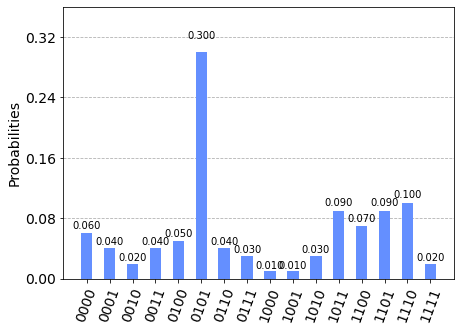

In [ ]:
### try a wining combination for a given board and only apply that combination see if it works
backend = provider.get_backend('ibmq_qasm_simulator')
job = execute(qc, backend=backend, shots=100, seed_simulator=12345, backend_options={"fusion_enable":True})
result = job.result()
count =result.get_counts()
#print(count)
plot_histogram(count) 

# Test Circuit

In [ ]:
# problem_name = [[input], 'answer']
q1 = [[[['0', '1'], ['0', '2'], ['1', '0'], ['2', '0'], ['3', '1'], ['3', '3']],
 [['0', '2'], ['0', '3'], ['1', '1'], ['1', '3'], ['2', '0'], ['2', '1']],
 [['0', '0'], ['0', '3'], ['2', '1'], ['2', '2'], ['3', '0'], ['3', '1']],
 [['0', '0'], ['0', '1'], ['0', '2'], ['1', '1'], ['2', '0'], ['3', '2']],
 [['0', '1'], ['1', '2'], ['1', '3'], ['2', '0'], ['3', '0'], ['3', '1']],
 [['0', '2'], ['0', '3'], ['1', '1'], ['2', '0'], ['2', '1'], ['3', '0']],
 [['0', '0'], ['0', '3'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '3']],
 [['0', '2'], ['1', '1'], ['1', '3'], ['2', '0'], ['2', '3'], ['3', '2']],
 [['0', '1'], ['0', '3'], ['2', '0'], ['2', '2'], ['3', '0'], ['3', '3']],
 [['0', '0'], ['0', '2'], ['1', '0'], ['2', '2'], ['2', '3'], ['3', '3']],
 [['1', '0'], ['1', '3'], ['2', '1'], ['2', '2'], ['3', '2'], ['3', '3']],
 [['0', '0'], ['1', '0'], ['2', '1'], ['2', '2'], ['3', '2'], ['3', '3']],
 [['0', '0'], ['1', '1'], ['1', '2'], ['2', '1'], ['2', '3'], ['3', '0']],
 [['0', '1'], ['0', '3'], ['2', '1'], ['2', '2'], ['3', '0'], ['3', '1']],
 [['0', '0'], ['0', '1'], ['1', '1'], ['1', '3'], ['3', '2'], ['3', '3']],
 [['0', '0'], ['0', '3'], ['1', '2'], ['1', '3'], ['3', '0'], ['3', '1']]], '6']
 q2 = [[[['0', '0'], ['0', '2'], ['1', '0'], ['1', '1'], ['3', '1'], ['3', '3']],
 [['0', '2'], ['0', '3'], ['1', '1'], ['1', '3'], ['2', '0'], ['2', '1']],
 [['0', '0'], ['1', '0'], ['2', '1'], ['2', '3'], ['3', '2'], ['3', '3']],
 [['0', '2'], ['0', '3'], ['1', '1'], ['1', '2'], ['3', '0'], ['3', '2']],
 [['0', '2'], ['0', '3'], ['2', '0'], ['2', '1'], ['3', '1'], ['3', '3']],
 [['0', '1'], ['0', '3'], ['1', '2'], ['1', '3'], ['2', '2'], ['3', '1']],
 [['0', '0'], ['1', '0'], ['2', '2'], ['2', '3'], ['3', '1'], ['3', '3']],
 [['0', '0'], ['0', '1'], ['1', '2'], ['2', '0'], ['3', '1'], ['3', '2']],
 [['0', '1'], ['0', '2'], ['1', '0'], ['1', '3'], ['3', '0'], ['3', '1']],
 [['0', '0'], ['0', '2'], ['1', '0'], ['1', '3'], ['2', '1'], ['2', '2']],
 [['0', '0'], ['0', '1'], ['0', '3'], ['1', '0'], ['2', '1'], ['3', '3']],
 [['0', '0'], ['0', '3'], ['1', '1'], ['1', '3'], ['2', '0'], ['2', '2']],
 [['0', '1'], ['1', '3'], ['2', '0'], ['2', '1'], ['2', '3'], ['3', '0']],
 [['0', '0'], ['1', '1'], ['2', '0'], ['2', '3'], ['3', '1'], ['3', '2']],
 [['0', '0'], ['0', '3'], ['1', '2'], ['2', '2'], ['3', '1'], ['3', '3']],
 [['0', '2'], ['0', '3'], ['1', '0'], ['1', '2'], ['2', '1'], ['2', '2']]], '13']
q3 = [[[['0', '2'], ['0', '3'], ['1', '1'], ['2', '0'], ['3', '0'], ['3', '1']],
 [['0', '1'], ['0', '3'], ['2', '0'], ['2', '2'], ['3', '0'], ['3', '1']],
 [['0', '0'], ['0', '3'], ['1', '1'], ['1', '3'], ['2', '2'], ['2', '3']],
 [['0', '2'], ['0', '3'], ['1', '0'], ['1', '1'], ['2', '3'], ['3', '1']],
 [['0', '1'], ['0', '2'], ['1', '0'], ['2', '0'], ['2', '3'], ['3', '3']],
 [['0', '3'], ['1', '0'], ['1', '2'], ['2', '1'], ['2', '2'], ['3', '3']],
 [['0', '1'], ['0', '3'], ['2', '0'], ['2', '3'], ['3', '2'], ['3', '3']],
 [['1', '0'], ['1', '1'], ['2', '1'], ['2', '3'], ['3', '2'], ['3', '3']],
 [['0', '1'], ['0', '2'], ['1', '0'], ['1', '3'], ['2', '3'], ['3', '0']],
 [['0', '0'], ['1', '1'], ['1', '3'], ['2', '0'], ['3', '2'], ['3', '3']],
 [['0', '1'], ['0', '2'], ['1', '3'], ['2', '0'], ['3', '0'], ['3', '3']],
 [['0', '0'], ['0', '1'], ['2', '0'], ['2', '3'], ['3', '2'], ['3', '3']],
 [['0', '3'], ['1', '0'], ['1', '2'], ['2', '2'], ['3', '0'], ['3', '3']],
 [['0', '0'], ['0', '3'], ['1', '0'], ['1', '1'], ['2', '0'], ['2', '2']],
 [['0', '1'], ['0', '3'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '2']],
 [['0', '2'], ['0', '3'], ['1', '3'], ['2', '0'], ['2', '2'], ['3', '0']]], '3']

qc = week3_ans_func(problem_set)
backend = provider.get_backend('ibmq_qasm_simulator')
job = execute(qc, backend=backend, shots=5000, seed_simulator=12345, backend_options={"fusion_enable":True})
result = job.result()
count =result.get_counts()
print(count)
plot_histogram(count)

# Submit Circuit

In [ ]:
job = prepare_ex3(week3_ans_func)
result = job.result()
counts = result.get_counts()
original_problem_set_counts = counts[0]
original_problem_set_counts

Running week3_ans_func...
Computing cost...
Starting experiments. Please wait...
You may monitor the job (id: 5fc2d9e81dde84001b4c84c8) status and proceed to grading when it successfully completes.


In [ ]:
grade_ex3(job)

In [ ]:
submit_ex3(job)

In [ ]:
def oracle(qc, a, d, boards, counter, flag):
    """Shoot beams on all adresses (boards) and mark the unsolvable board.
    
    qc (QuantumCircuit) - The quantum circuit to prepare.
    a (QuantumRegister) - The adress registers.
    d (QuantumRegister) - The data registers.
    boards (list) - Initial configuration of [[board_0],[board_1],...,[board_15]].
    counter (QuantumRegister) - The counter qubit to represent a solved board.
    flag (QuantumRegister) - The ancilla for phase kickback.
    """          
    ## address_0 -> data_0 <=> |0000>|board_0> {V1,V3,V4}
    qc.x(a)                                 
    for asteroid in boards[0]: 
        if asteroid[1] == '0':  # V1
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])         
        if asteroid[1] == '2':  # V3
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])         
        if asteroid[1] == '3':  # V4
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])     
    qc.x(a)    
    ## address_1 -> data_1 <=> |1000>|board_1> {H1,H4,V3}
    qc.x(a[:-1])
    for asteroid in boards[1]: 
        if asteroid[0] == '0':  # H1
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])     
        if asteroid[0] == '3':  # H4
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])                 
        if asteroid[1] == '2':  # V3
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])         
    qc.x(a[:-1])
    ## address_2 -> data_2 <=> |0100>|board_2> {H2,H4,V1}
    qc.x([a[0],a[1],a[-1]])
    for asteroid in boards[2]: 
        if asteroid[0] == '1':  # H2
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])]) 
        if asteroid[0] == '3':  # H4
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])     
        if asteroid[1] == '0':  # V1
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])         
    qc.x([a[0],a[1],a[-1]])    
    ## address_3 -> data_3 <=> |1100>|board_3> {H1,H2,H4}
    qc.x(a[:2])
    for asteroid in boards[3]: 
        if asteroid[0] == '0':  # H1
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])            
        if asteroid[0] == '1':  # H2
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])]) 
        if asteroid[0] == '3':  # H4
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])        
    qc.x(a[:2])
    ## address_4 -> data_4 <=> |0010>|board_4> {V1,V3,V4}
    qc.x([a[0],a[2],a[-1]])
    for asteroid in boards[4]: 
        if asteroid[1] == '0':  # V1
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])      
        if asteroid[1] == '2':  # V3
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])   
        if asteroid[1] == '3':  # V4
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])                 
    qc.x([a[0],a[2],a[-1]])
    ## address_5 -> data_5 <=> |1010>|board_5> {H2,H3,H4}
    qc.x(a[::2])
    for asteroid in boards[5]: 
        if asteroid[0] == '1':  # H2
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])]) 
        if asteroid[0] == '2':  # H3
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])             
        if asteroid[0] == '3':  # H4
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])         
    qc.x(a[::2])    
    ## address_6 -> data_6 <=> |0110>|board_6> {H3,V3,V4} 
    qc.x([a[0],a[-1]])
    for asteroid in boards[6]: 
        if asteroid[0] == '2':  # H3
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])   
        if asteroid[1] == '2':  # V3
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])   
        if asteroid[1] == '3':  # V4
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])             
    qc.x([a[0],a[-1]])   
    ## address_7 -> data_7 <=> |1110>|board_7>
    qc.x(a[0])
    for asteroid in boards[7]: 
        if asteroid[1] == '0':  # V1
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])          
        if asteroid[1] == '2':  # V3
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])   
        if asteroid[1] == '3':  # V4
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])      
    qc.x(a[0])
    ## address_8 -> data_8 <=> |0001>|board_8>
    qc.x(a[1:])
    for asteroid in boards[8]: 
        if asteroid[0] == '1':  # H2
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])         
        if asteroid[0] == '2':  # H3
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])           
        if asteroid[1] == '3':  # V4
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])      
    qc.x(a[1:])
    ## address_9 -> data_9 <=> |1001>|board_9>
    qc.x(a[1:3])
    for asteroid in boards[9]: 
        if asteroid[1] == '0':  # V1
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])          
        if asteroid[1] == '1':  # V2
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])   
        if asteroid[1] == '3':  # V4
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])      
    qc.x(a[1:3])
    ## address_10 -> data_10 <=> |0101>|board_10>
    qc.x(a[1::2])
    ###### This is the unsolvable board.     
    qc.x(a[1::2])
    ## address_11 -> data_11 <=> |1101>|board_11> {V1,V2,V4}
    qc.x(a[1])
    for asteroid in boards[11]: 
        if asteroid[1] == '0':  # V1
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])          
        if asteroid[1] == '1':  # V2
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])   
        if asteroid[1] == '3':  # V4
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])       
    qc.x(a[1])
    ## address_12 -> data_12 <=> |0011>|board_12> {H1,H2,H3}
    qc.x(a[2:])
    for asteroid in boards[12]: 
        if asteroid[0] == '0':  # H1
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])          
        if asteroid[0] == '1':  # H2
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])   
        if asteroid[0] == '2':  # H3
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])       
    qc.x(a[2:])
    ## address_13 -> data_13 <=> |1011>|board_13> {H3,V1,V4}
    qc.x(a[2])
    for asteroid in boards[13]: 
        if asteroid[0] == '2':  # H3
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])    
        if asteroid[1] == '0':  # V1
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])          
        if asteroid[1] == '3':  # V4
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])]) 
    qc.x(a[2])
    ## address_14 -> data_14 <=> |0111>|board_14> {H4,V3,V4}
    qc.x(a[-1])
    for asteroid in boards[14]: 
        if asteroid[0] == '3':  # H4
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])       
        if asteroid[1] == '2':  # V3
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])       
        if asteroid[1] == '3':  # V4
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])     
    qc.x(a[-1])
    ## address_15 -> data_15 <=> |1111>|board_15>
    for asteroid in boards[15]: 
        if asteroid[1] == '0':  # V1
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])  
        if asteroid[1] == '1':  # V2
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])              
        if asteroid[1] == '2':  # V3
            qc.mct(a,d[int(asteroid[0])*4+int(asteroid[1])])    
    ### Count asteroids in each board. If board is solved (all zeros) increase counter.
    qc.h(flag) # For phase kickback
    qc.x(d)
    qc.mct(d,counter)
    ### If counter is zero cx the flag qubit and that will mark the adress of that board.
    qc.cx(counter, flag)
    qc.x(d)    